## Process
    1) Load & prepare data set
    2) CNN baseline model
    3) Transfer learning exploiting keras application modules

### 1) Load & prepare data set

In [13]:
import glob,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import models,layers
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

In [2]:
label_dict = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}

In [3]:
os.getcwd()

'C:\\Users\\Kyungbin Choi\\Desktop\\cv_study\\intel_img_cls'

In [3]:
glob.glob('./archive/seg_train/seg_train/*')

['./archive/seg_train/seg_train\\buildings',
 './archive/seg_train/seg_train\\forest',
 './archive/seg_train/seg_train\\glacier',
 './archive/seg_train/seg_train\\mountain',
 './archive/seg_train/seg_train\\sea',
 './archive/seg_train/seg_train\\street']

In [4]:
glob.glob('./archive/seg_test/seg_test/*')

['./archive/seg_test/seg_test\\buildings',
 './archive/seg_test/seg_test\\forest',
 './archive/seg_test/seg_test\\glacier',
 './archive/seg_test/seg_test\\mountain',
 './archive/seg_test/seg_test\\sea',
 './archive/seg_test/seg_test\\street']

In [5]:
tmp_repo_list = glob.glob('./archive/seg_train/seg_train/buildings*')
len(glob.glob(tmp_repo_list[0]+'/*.jpg'))

2191

In [6]:
tmp_repo_list = glob.glob('./archive/seg_train/seg_train/forest*')
len(glob.glob(tmp_repo_list[0]+'/*.jpg'))

2271

In [8]:
def img_data_load(repository, y_label, img_size=150):
    X_data =[]
    y_data =[]
    all_files = glob.glob(repository[0]+'/*.jpg')
    print(len(all_files))
    for img_file in all_files:
        smp = load_img(img_file, target_size=(img_size,img_size))
        train_smp = img_to_array(smp)
        train_smp = train_smp/255. #normalize values
        X_data.append(train_smp)
        y_data.append(np.array(y_label,dtype = 'int32'))
    return X_data, y_data

In [9]:
X_val_list = []
y_val_list = []
for label_, val_ in label_dict.items():
    print(label_, val_)
    repo = glob.glob('./archive/seg_train/seg_train/'+label_+'*')
    X_, y_ = img_data_load(repo, val_)
    X_val_list.append(X_)
    y_val_list.append(y_)

buildings 0
2191
forest 1
2271
glacier 2
2404
mountain 3
2512
sea 4
2274
street 5
2382


In [10]:
X_train = np.concatenate(X_val_list)
y_train = np.concatenate(y_val_list)

In [11]:
X_val_test_list = []
y_val_test_list = []
for label_, val_ in label_dict.items():
    print(label_, val_)
    repo = glob.glob('./archive/seg_test/seg_test/'+label_+'*')
    X_, y_ = img_data_load(repo, val_)
    X_val_test_list.append(X_)
    y_val_test_list.append(y_)

buildings 0
437
forest 1
474
glacier 2
553
mountain 3
525
sea 4
510
street 5
501


In [12]:
X_test = np.concatenate(X_val_test_list)
y_test = np.concatenate(y_val_test_list)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, 
                                                    test_size=500, 
                                                    shuffle=True, 
                                                    random_state=1)

In [14]:
np.save('X_train.npy',X_train)
np.save('y_train.npy',y_train)

np.save('X_val.npy',X_val)
np.save('y_val.npy',y_val)

np.save('X_test.npy',X_test)
np.save('y_test.npy',y_test)

## 2) Baseline model

In [4]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [5]:
label_dict

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [6]:
y_train.shape

(13534,)

In [7]:
X_train.shape

(13534, 150, 150, 3)

In [8]:
X_val.shape

(500, 150, 150, 3)

In [9]:
(X_train.shape[1:])

(150, 150, 3)

In [10]:
X_train, y_train = shuffle(X_train, y_train)

In [11]:
def basic_cnn(X_train, y_train, X_val_, y_val_):
    inputs_ = layers.Input(shape=(X_train.shape[1:]))
    conv_layer1 = layers.Conv2D(32, kernel_size=(3,3), activation = 'relu')(inputs_)
    conv_layer2 = layers.Conv2D(64, kernel_size=(3,3), activation = 'relu')(conv_layer1)
    pool = layers.MaxPool2D((2,2))(conv_layer2)
    dropout = layers.Dropout(0.2)(pool)
    flatten = layers.Flatten()(dropout)
    dense_layer = layers.Dense(128, activation='relu')(flatten)
    output = layers.Dense(len(label_dict.keys()), activation='softmax')(dense_layer)
    model = models.Model(inputs=inputs_, outputs=output)
    adam = tf.keras.optimizers.Adam(.001)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val_, y_val_), batch_size = 64, epochs = 20)
    
    return model, history

In [12]:
baseline_cnn, history = basic_cnn(X_train, y_train, X_val, y_val)

Epoch 1/20
212/212 [==============================] - 33s 155ms/step - loss: 1.3654 - accuracy: 0.5994 - val_loss: 0.7314 - val_accuracy: 0.7460
Epoch 2/20
212/212 [==============================] - 31s 146ms/step - loss: 0.5697 - accuracy: 0.7985 - val_loss: 0.7136 - val_accuracy: 0.7660
Epoch 3/20
212/212 [==============================] - 32s 149ms/step - loss: 0.3041 - accuracy: 0.9014 - val_loss: 0.7096 - val_accuracy: 0.7800
Epoch 4/20
212/212 [==============================] - 32s 153ms/step - loss: 0.1273 - accuracy: 0.9635 - val_loss: 0.8238 - val_accuracy: 0.7760
Epoch 5/20
212/212 [==============================] - 32s 149ms/step - loss: 0.0565 - accuracy: 0.9869 - val_loss: 0.9260 - val_accuracy: 0.7660
Epoch 6/20
212/212 [==============================] - 31s 148ms/step - loss: 0.0488 - accuracy: 0.9888 - val_loss: 0.9771 - val_accuracy: 0.7760
Epoch 7/20
212/212 [==============================] - 31s 148ms/step - loss: 0.0452 - accuracy: 0.9899 - val_loss: 1.0184 - val_ac

In [14]:
baseline_cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 341056)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               436552

In [16]:
baseline_cnn.evaluate(X_test, y_test)

94/94 [==============================] - 3s 28ms/step - loss: 1.2858 - accuracy: 0.7807


[1.285772681236267, 0.7806666493415833]

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

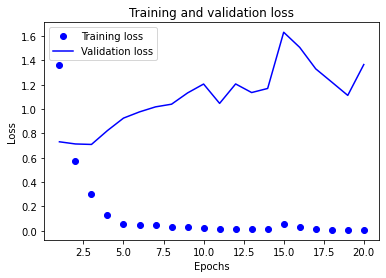

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
def basic_cnn2(X_train, y_train, X_val_, y_val_):
    inputs_ = layers.Input(shape=(X_train.shape[1:]))
    conv_layer1 = layers.Conv2D(32, kernel_size=(3,3), activation = 'relu')(inputs_)
    conv_layer2 = layers.Conv2D(64, kernel_size=(3,3), activation = 'relu')(conv_layer1)
    pool = layers.MaxPool2D((2,2))(conv_layer2)
    dropout1 = layers.Dropout(0.2)(pool)
    flatten = layers.Flatten()(dropout1)
    dense_layer1 = layers.Dense(128, activation='relu')(flatten)
    dropout2 = layers.Dropout(0.2)(dense_layer1)
    dense_layer2 = layers.Dense(32, activation='relu')(dropout2)
    output = layers.Dense(len(label_dict.keys()), activation='softmax')(dense_layer2)
    model = models.Model(inputs=inputs_, outputs=output)
    adam = tf.keras.optimizers.Adam(2e-4)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val_, y_val_), batch_size = 64, epochs = 10)
    
    return model, history

In [28]:
baseline_cnn2, history2 = basic_cnn2(X_train, y_train, X_val, y_val)

Epoch 1/10
212/212 [==============================] - 32s 150ms/step - loss: 1.2094 - accuracy: 0.5273 - val_loss: 0.9495 - val_accuracy: 0.6800
Epoch 2/10
212/212 [==============================] - 31s 146ms/step - loss: 0.8217 - accuracy: 0.6966 - val_loss: 0.7065 - val_accuracy: 0.7500
Epoch 3/10
212/212 [==============================] - 31s 146ms/step - loss: 0.6351 - accuracy: 0.7693 - val_loss: 0.6349 - val_accuracy: 0.8000
Epoch 4/10
212/212 [==============================] - 31s 145ms/step - loss: 0.5061 - accuracy: 0.8199 - val_loss: 0.6063 - val_accuracy: 0.8100
Epoch 5/10
212/212 [==============================] - 31s 146ms/step - loss: 0.3913 - accuracy: 0.8654 - val_loss: 0.6034 - val_accuracy: 0.7800
Epoch 6/10
212/212 [==============================] - 31s 146ms/step - loss: 0.3045 - accuracy: 0.9003 - val_loss: 0.5660 - val_accuracy: 0.8100
Epoch 7/10
212/212 [==============================] - 31s 146ms/step - loss: 0.2293 - accuracy: 0.9240 - val_loss: 0.6037 - val_ac

In [29]:
baseline_cnn2.evaluate(X_test, y_test)

94/94 [==============================] - 2s 25ms/step - loss: 0.7670 - accuracy: 0.7863


[0.7670224905014038, 0.7863333225250244]

In [38]:
base_model = tf.keras.applications.MobileNetV2(input_shape=X_train.shape[1:],
                                               include_top=False,
                                               weights='imagenet')

In [47]:
train_features = base_model.predict(X_train)
test_features = base_model.predict(X_test)
val_features = base_model.predict(X_val)

In [48]:
def transfer_model(X_feature, y_train, X_val_, y_val_):
    inputs_ = layers.Input(shape=(X_feature.shape[1:]))
    flatten = layers.Flatten()(inputs_)
    dense_layer1 = layers.Dense(128, activation='relu')(flatten)
    dropout1 = layers.Dropout(0.2)(dense_layer1)
    dense_layer2 = layers.Dense(32, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.2)(dense_layer2)
    output = layers.Dense(len(label_dict.keys()), activation='softmax')(dense_layer2)
    model = models.Model(inputs=inputs_, outputs=output)
    adam = tf.keras.optimizers.Adam(2e-4)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_feature, y_train, validation_data=(X_val_, y_val_), batch_size = 64, epochs = 20)
    return model, history

In [49]:
mobilenetv2_feature_model, history = transfer_model(train_features, y_train,  val_features, y_val)

Epoch 1/10
212/212 [==============================] - 1s 7ms/step - loss: 0.4411 - accuracy: 0.8456 - val_loss: 0.2824 - val_accuracy: 0.9120
Epoch 2/10
212/212 [==============================] - 1s 6ms/step - loss: 0.2483 - accuracy: 0.9104 - val_loss: 0.2832 - val_accuracy: 0.9120
Epoch 3/10
212/212 [==============================] - 1s 6ms/step - loss: 0.1823 - accuracy: 0.9337 - val_loss: 0.2619 - val_accuracy: 0.9300
Epoch 4/10
212/212 [==============================] - 1s 6ms/step - loss: 0.1393 - accuracy: 0.9494 - val_loss: 0.3052 - val_accuracy: 0.9340
Epoch 5/10
212/212 [==============================] - 1s 6ms/step - loss: 0.1024 - accuracy: 0.9634 - val_loss: 0.2675 - val_accuracy: 0.9400
Epoch 6/10
212/212 [==============================] - 1s 6ms/step - loss: 0.0745 - accuracy: 0.9730 - val_loss: 0.2997 - val_accuracy: 0.9360
Epoch 7/10
212/212 [==============================] - 1s 6ms/step - loss: 0.0616 - accuracy: 0.9784 - val_loss: 0.3645 - val_accuracy: 0.9200
Epoch 

In [51]:
mobilenetv2_feature_model.evaluate(test_features, y_test)

94/94 [==============================] - 0s 4ms/step - loss: 0.3596 - accuracy: 0.9070


[0.35964351892471313, 0.9070000052452087]

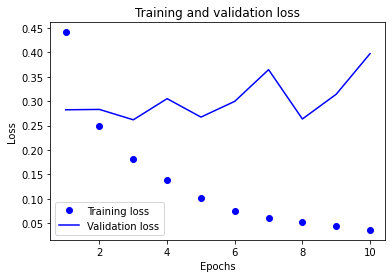

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()